In [1]:
# !pip install -U pymoo
# !pip install optuna

In [2]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Binary
from pymoo.optimize import minimize
from pymoo.core.mixed import MixedVariableGA
from pymoo.algorithms.soo.nonconvex.optuna import Optuna

In [3]:
# config
n_years = 3
n_yearly_max_metric = 1
n_yearly_min_metric = 1

yearly_max_metric_constraint = {'Group CAPEX, MYR mm': [10000000, 10000000, 10000000]}
yearly_min_metric_constraint = {'Group Revenue, MYR mm': [10, 10, 10]}

In [4]:
# define functions to get objective function and constraints
def get_metric(X, target_metric):
    if target_metric == 'Group EV, MYR mm':
        expr = n_years*(1000*X['x1'] + max(2000*X['x2'], 5))
        return -expr
    
def get_yearly_max_metric_constraint(X, metric, year):
    LHS = 500*X['x1'] + 1000*X['x2']
    RHS = yearly_max_metric_constraint[metric][year]
    return LHS - RHS

def get_yearly_min_metric_constraint(X, metric, year):
    LHS = 1000*X['x1'] + 2000*X['x2']
    RHS = yearly_min_metric_constraint[metric][year]
    return RHS - LHS

In [5]:
# define problem class
class MixedVariableProblem(ElementwiseProblem):

    def __init__(self, target_metric, **kwargs):
        # define decision variables
        vars = {
            "x1": Integer(bounds=(0, 10)),
            "x2": Integer(bounds=(0, 5))
        }
        super().__init__(
            vars=vars, 
            n_obj=1, 
            n_ieq_constr=(n_years*n_yearly_max_metric) + (n_years*n_yearly_min_metric), 
            **kwargs
        )
        self.target_metric = target_metric

    def _evaluate(self, X, out, *args, **kwargs):
        
        # get objective value, assign to F
        out["F"] = get_metric(X, self.target_metric)
        
        # get constraints 
        out["G"] = []
        # get yearly max metric constraints, append to G
        for metric in yearly_max_metric_constraint.keys():
            for year in range(n_years):
                out["G"].append(get_yearly_max_metric_constraint(X, metric, year))
        # get yearly min metric constraints, append to G
        for metric in yearly_min_metric_constraint.keys():
            for year in range(n_years):
                out["G"].append(get_yearly_min_metric_constraint(X, metric, year))

In [6]:
# instantiate problem
problem = MixedVariableProblem(target_metric = 'Group EV, MYR mm')

# define algorithm to be used
# algorithm = MixedVariableGA(pop=10)
algorithm = Optuna()

# run optimization
res = minimize(problem,
               algorithm,
               termination=('n_evals', 100),
               seed=1,
               verbose=True,
               save_history=True)

# print best solution
print("Best solution found: \nX = %s\nF = %s" % (res.X, -res.F))
print(f"Run time: {res.exec_time:.2f} seconds")

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |        1 |  0.000000E+00 |  0.000000E+00 | -3.600000E+04 | -3.600000E+04
     2 |        2 |  0.000000E+00 |  0.000000E+00 | -6.000000E+03 | -3.600000E+04
     3 |        3 |  0.000000E+00 |  0.000000E+00 | -3.015000E+03 | -3.600000E+04
     4 |        4 |  0.000000E+00 |  0.000000E+00 | -1.800000E+04 | -3.600000E+04
     5 |        5 |  0.000000E+00 |  0.000000E+00 | -3.000000E+04 | -3.600000E+04
     6 |        6 |  0.000000E+00 |  0.000000E+00 | -3.600000E+04 | -3.600000E+04
     7 |        7 |  0.000000E+00 |  0.000000E+00 | -3.600000E+04 | -3.600000E+04
     8 |        8 |  0.000000E+00 |  0.000000E+00 | -2.400000E+04 | -3.600000E+04
     9 |        9 |  0.000000E+00 |  0.000000E+00 | -3.000000E+04 | -3.600000E+04
    10 |       10 |  0.000000E+00 |  0.000000E+00 | -9.000000E+03 | -3.600000E+04
    11 |       11 |  0.000000E+00 |  0.000000E+00 | -5.700000E+04 | -5.700000E+04
    12 |       1

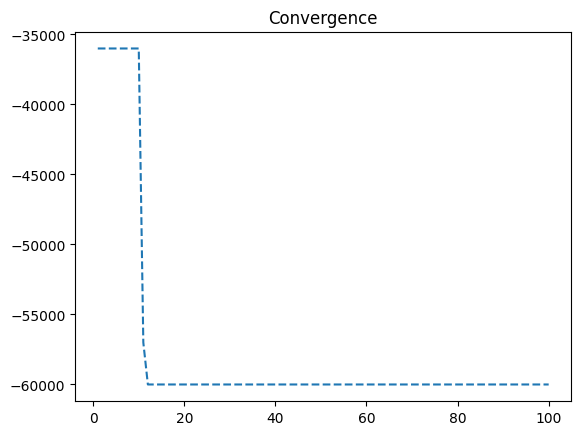

In [7]:
import numpy as np
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
# plt.yscale("log")
plt.show()